# **Imports i ucitavanje fajla**

In [117]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import  plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from io import StringIO
from xgboost import XGBRegressor
from docx import Document

file = pd.read_csv("student-por.csv")

              age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     3.930663    3.180277    3.184900    1.502311    2.280431    3.536210   
std      0.955717    1.0510

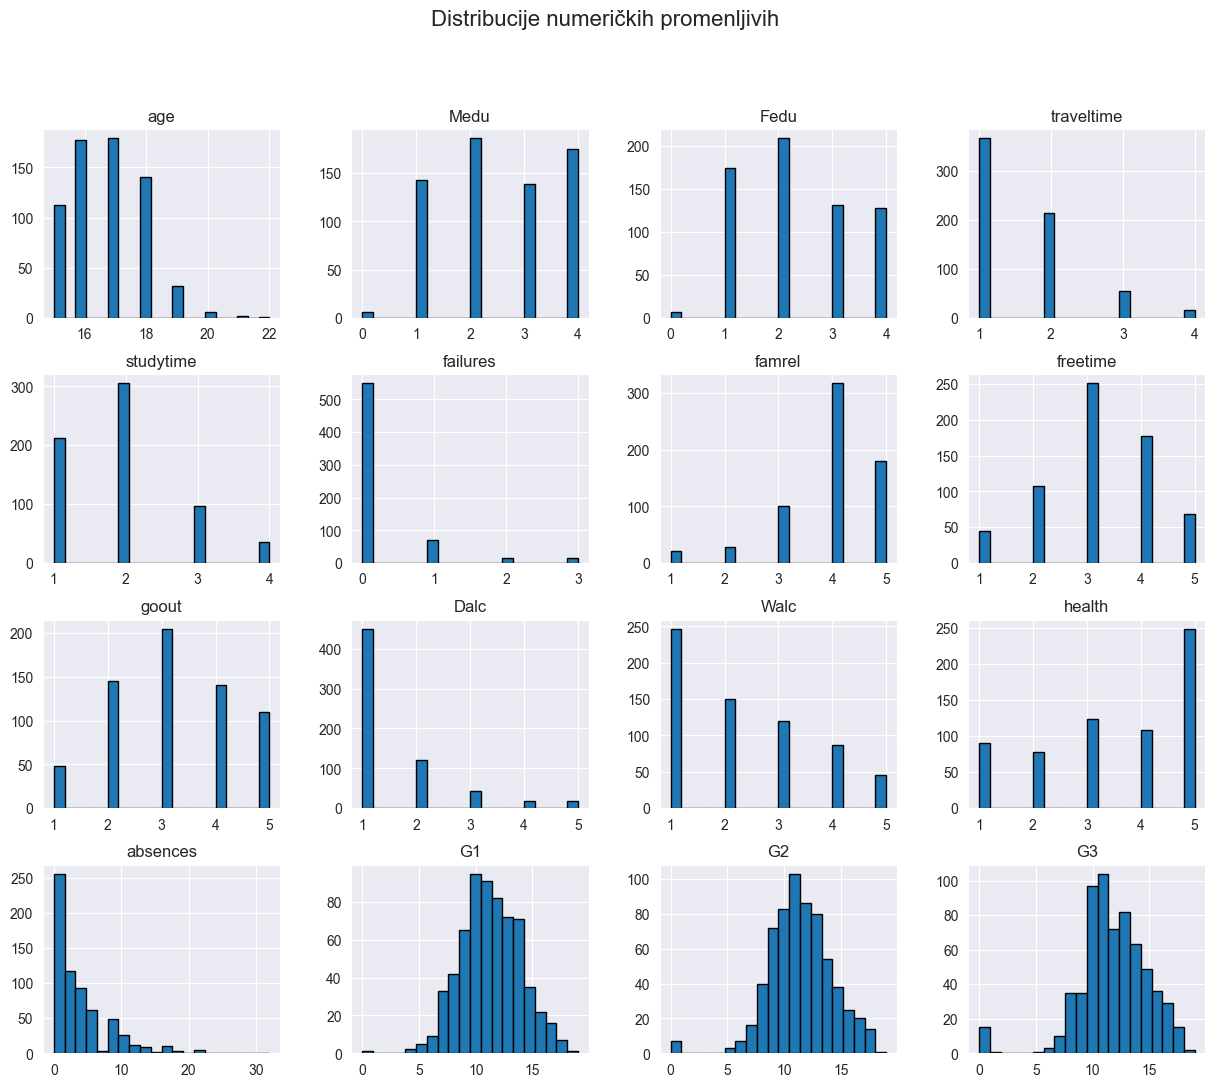

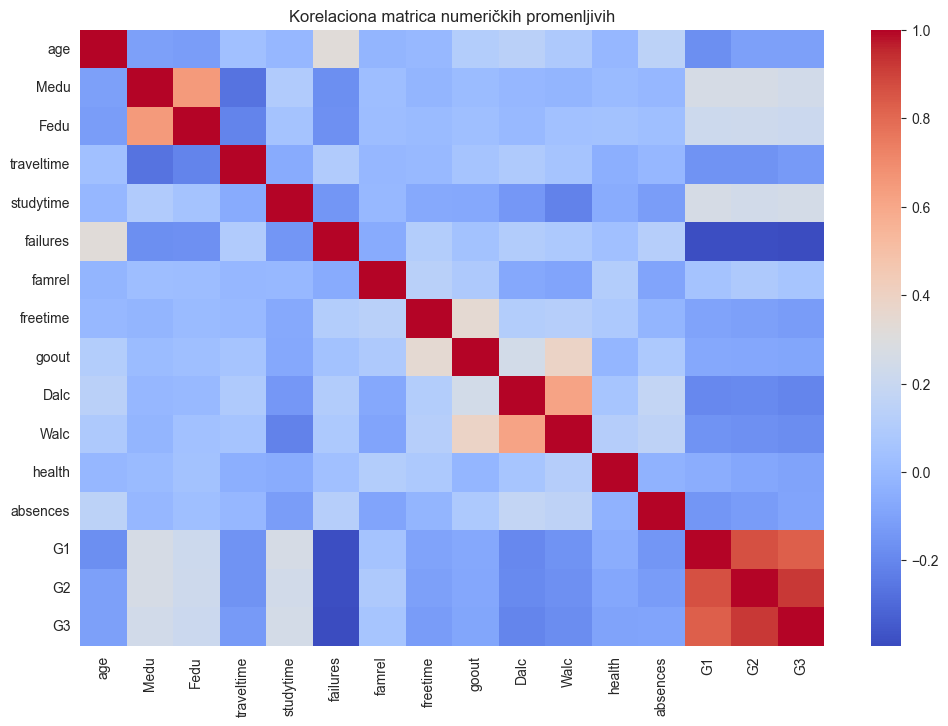

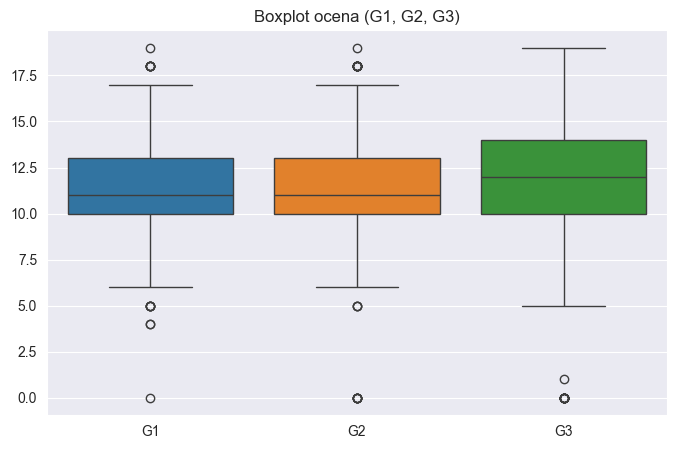

C:\Users\luca\AppData\Local\Temp\ipykernel_22964\2911460216.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




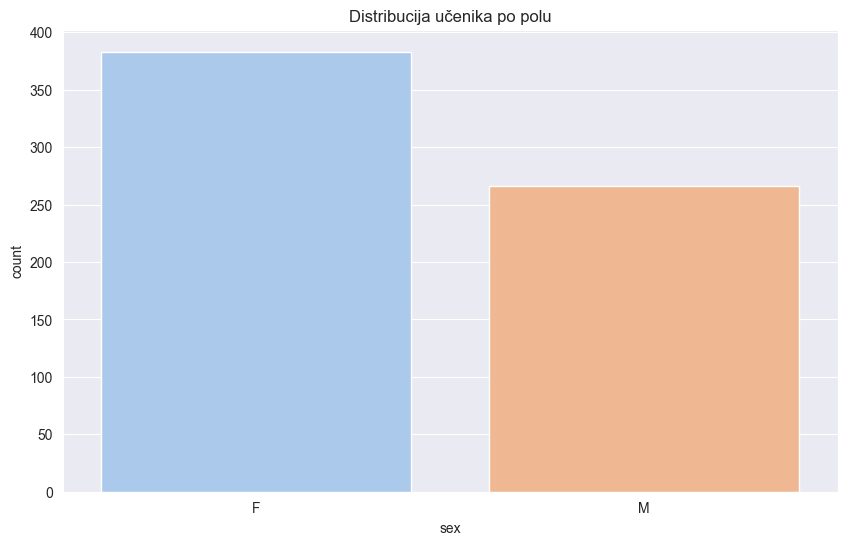

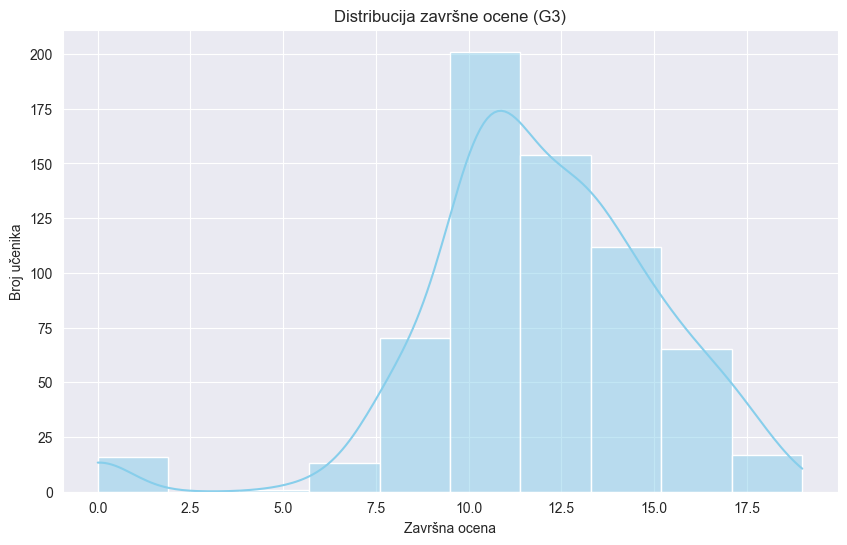

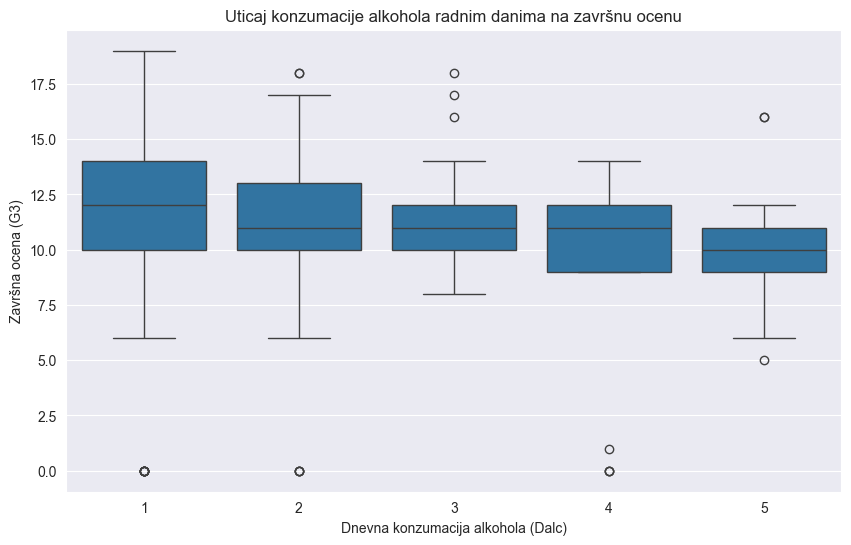

In [118]:
plt.rcParams['figure.figsize'] = (10, 6)

print(file.describe())

file.hist(bins=20, edgecolor='black', figsize=(15, 12))
plt.suptitle("Distribucije numeričkih promenljivih", fontsize=16)
plt.savefig('student-por-analasys.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(file.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Korelaciona matrica numeričkih promenljivih")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=file[['G1', 'G2', 'G3']])
plt.title("Boxplot ocena (G1, G2, G3)")
plt.show()

sns.countplot(x='sex', data=file, palette='pastel')
plt.title("Distribucija učenika po polu")
plt.show()

sns.histplot(file['G3'], bins=10, kde=True, color='skyblue')
plt.title("Distribucija završne ocene (G3)")
plt.xlabel("Završna ocena")
plt.ylabel("Broj učenika")
plt.savefig('DistribucijaG3.png', dpi=300)
plt.show()

sns.boxplot(x='Dalc', y='G3', data=file)
plt.title("Uticaj konzumacije alkohola radnim danima na završnu ocenu")
plt.xlabel("Dnevna konzumacija alkohola (Dalc)")
plt.ylabel("Završna ocena (G3)")
plt.show()

**Posmatranje korelacije G1, G2 i G3**

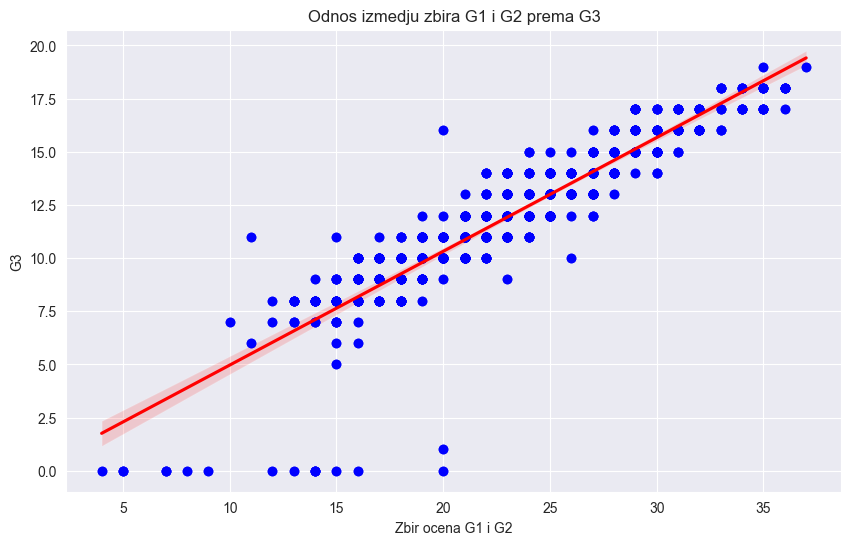

G1            0
G2           11
G3           11
ZbirOcena    11
Name: 0, dtype: int64


In [119]:
df = DataFrame(file[['G1','G2','G3']])

df['ZbirOcena'] = df['G1'] + df['G2']

sns.regplot(x='ZbirOcena', y='G3', data=df, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.scatter(df['ZbirOcena'], df['G3'], color='blue')
plt.xlabel('Zbir ocena G1 i G2')
plt.ylabel('G3')
plt.title('Odnos izmedju zbira G1 i G2 prema G3')
plt.savefig('KorelacijaG1G2G3.png', dpi=300)
plt.show()

fig = px.scatter_3d(
    df,
    x='G1',
    y='G2',
    z='G3',
    color='G1',
    title='3d plot odnosa'
)

for i in range(0,1):
    print(df.iloc[i])

fig.update_traces(marker=dict(size=5))
fig.show()

buffer = StringIO()
file.info(buf=buffer)
info_str = buffer.getvalue()

with open('info.csv', 'w') as f:
    f.write(info_str)

# **Obrada anomalija kod G1, G2 i G3**

In [120]:
pre = len(file)

file = file.dropna()
file = file.drop_duplicates()

#iqrs = stats.iqr(file['G3'])

to_drop = []

#Obrada anomalija sa z-score

zscore_G1 = list()
zscore_G1 = file['G1']
zscore_G1 = stats.zscore(zscore_G1)

zscore_G2 = list()
zscore_G2 = file['G2']
zscore_G2 = stats.zscore(zscore_G2)

zscore_G3 = list()
zscore_G3 = file['G3']
zscore_G3 = stats.zscore(zscore_G3)

for i, row in file.iterrows():  #zbir ocena polugodista razlicit od 0, a finalna ocena 0
    if (row['G1'] + row['G2']) != 0 and row['G3'] == 0:
        to_drop.append(i)
    elif row['G1'] == 0 and row['G2'] == 0 and row['G3'] != 0:
        to_drop.append(i)
    elif row['G1'] == 0 and row['G2'] != 0 and row['G3'] != 0:
        to_drop.append(i)
    elif row['G1'] != 0 and row['G2'] == 0 and row['G3'] != 0:
        to_drop.append(i)
    # elif row['G3'] > iqrs or row['G3'] < iqrs:
    #     to_drop.append(i)
    elif abs(zscore_G3[i]) > 2:
        to_drop.append(i)
    elif abs(zscore_G1[i]) > 2:
        to_drop.append(i)
    elif abs(zscore_G2[i]) > 2:
        to_drop.append(i)

file.drop(to_drop, inplace=True)

#Obrada anomalija sa IQR metodom

Q1 = file['G3'].quantile(0.25)
Q3 = file['G3'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_above = file[file['G3'] > upper_limit]
outliers_below = file[file['G3'] < lower_limit]

print("Anomalije iznad gornje granice:\n", outliers_above)
print("\nAnomalije ispod donje granice:\n", outliers_below)

file = file[(file['G3'] >= lower_limit) & (file['G3'] <= upper_limit)]

post = len(file)
print(f"Uklonjenih anomalija: {pre - post}")

Anomalije iznad gornje granice:
 Empty DataFrame
Columns: [school, sex, age, address, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3]
Index: []

[0 rows x 33 columns]

Anomalije ispod donje granice:
 Empty DataFrame
Columns: [school, sex, age, address, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3]
Index: []

[0 rows x 33 columns]
Uklonjenih anomalija: 47


# **Izgled G1, G2 i G3 nakon obrade**

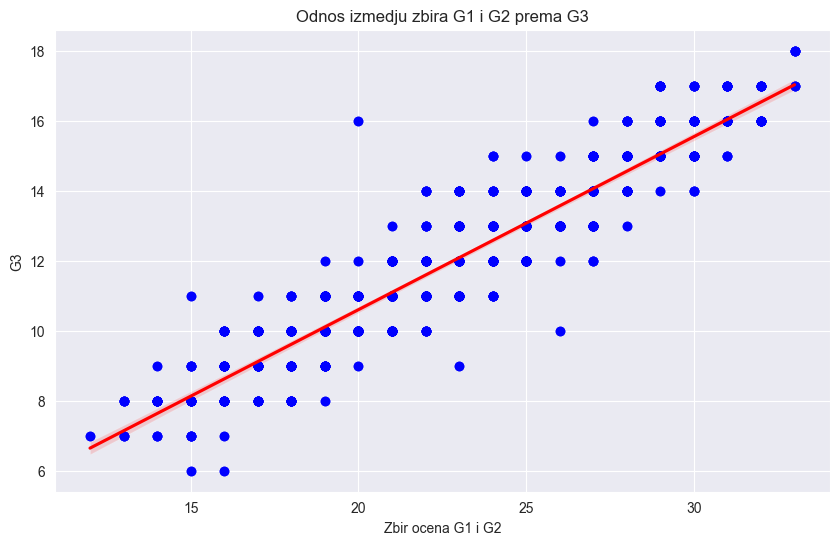

G1            9
G2           11
G3           11
ZbirOcena    20
Name: 1, dtype: int64


In [121]:
df = DataFrame(file[['G1','G2','G3']])

df['ZbirOcena'] = df['G1'] + df['G2']

sns.regplot(x='ZbirOcena', y='G3', data=df, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.scatter(df['ZbirOcena'], df['G3'], color='blue')
plt.xlabel('Zbir ocena G1 i G2')
plt.ylabel('G3')
plt.title('Odnos izmedju zbira G1 i G2 prema G3')
plt.savefig('KorelacijaG1G2.png', dpi=300)
plt.show()

fig = px.scatter_3d(
    df,
    x='G1',
    y='G2',
    z='G3',
    color='G1',
    title='3d plot odnosa'
)

for i in range(0,1):
    print(df.iloc[i])

fig.update_traces(marker=dict(size=5))
fig.show()

# **Encodiranje podataka**

In [122]:
#One-hot encoding
file = pd.get_dummies(file,columns=['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities','nursery', 'higher', 'internet', 'romantic'],drop_first=True)

#Frequency encoding (Gleda se broj pojavljivanja podatka pa se vrednost redova zameni tom vrednoscu)
for col in ['Mjob', 'Fjob', 'reason', 'guardian']:
    freq = file[col].value_counts(normalize=True)
    file[col] = file[col].map(freq)

#file.to_csv('dummies.csv', index=False)

# **Skaliranje podataka**

In [123]:
scaler = StandardScaler()
file = pd.DataFrame(
    scaler.fit_transform(file),
    columns=file.columns,
    index=file.index
)


# **Pronalazenje korelacija izmedju podataka**

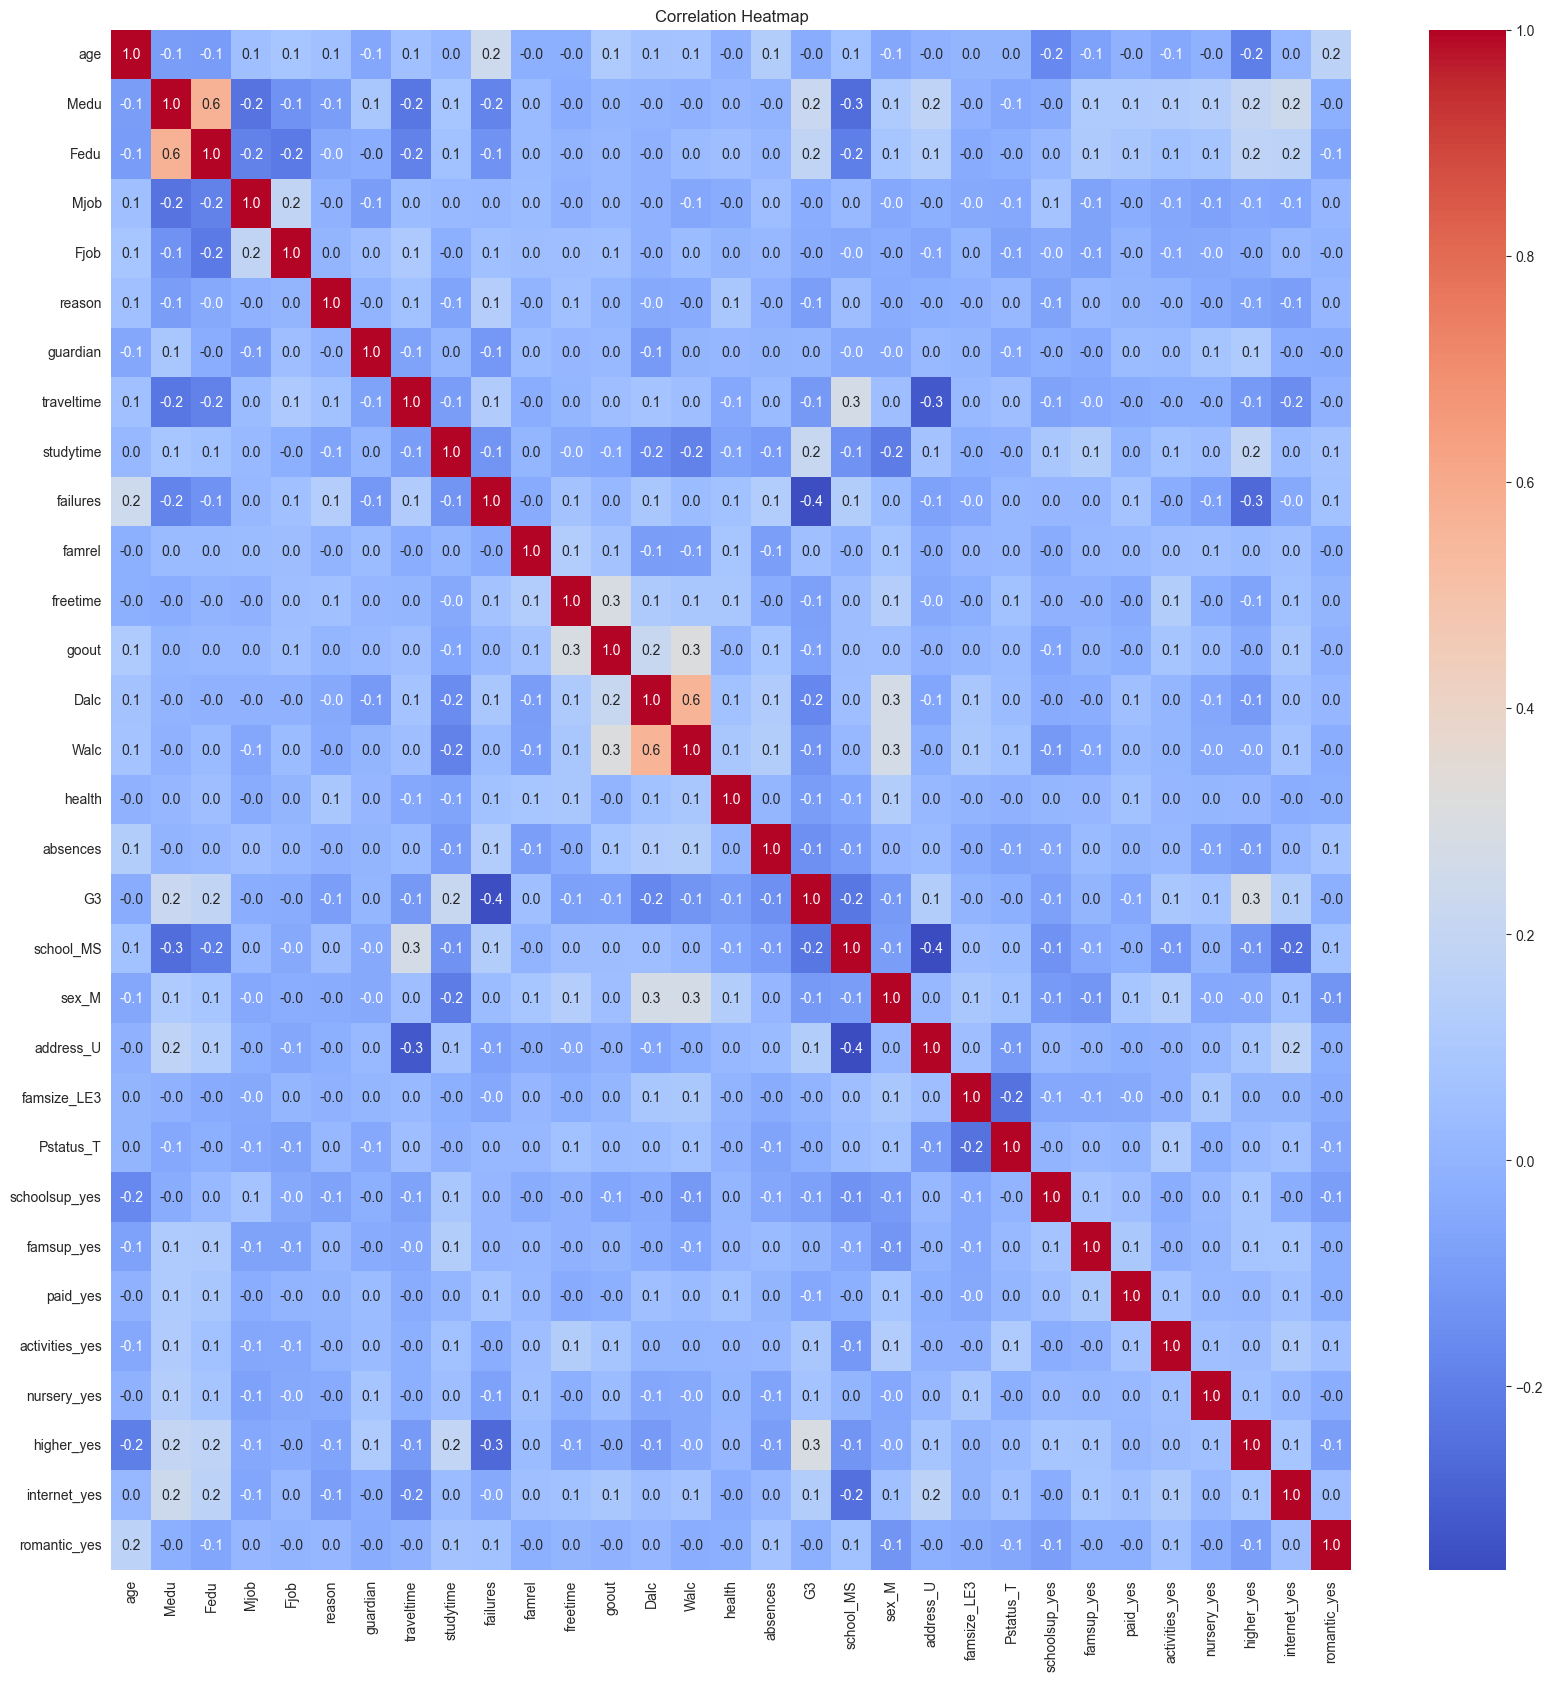

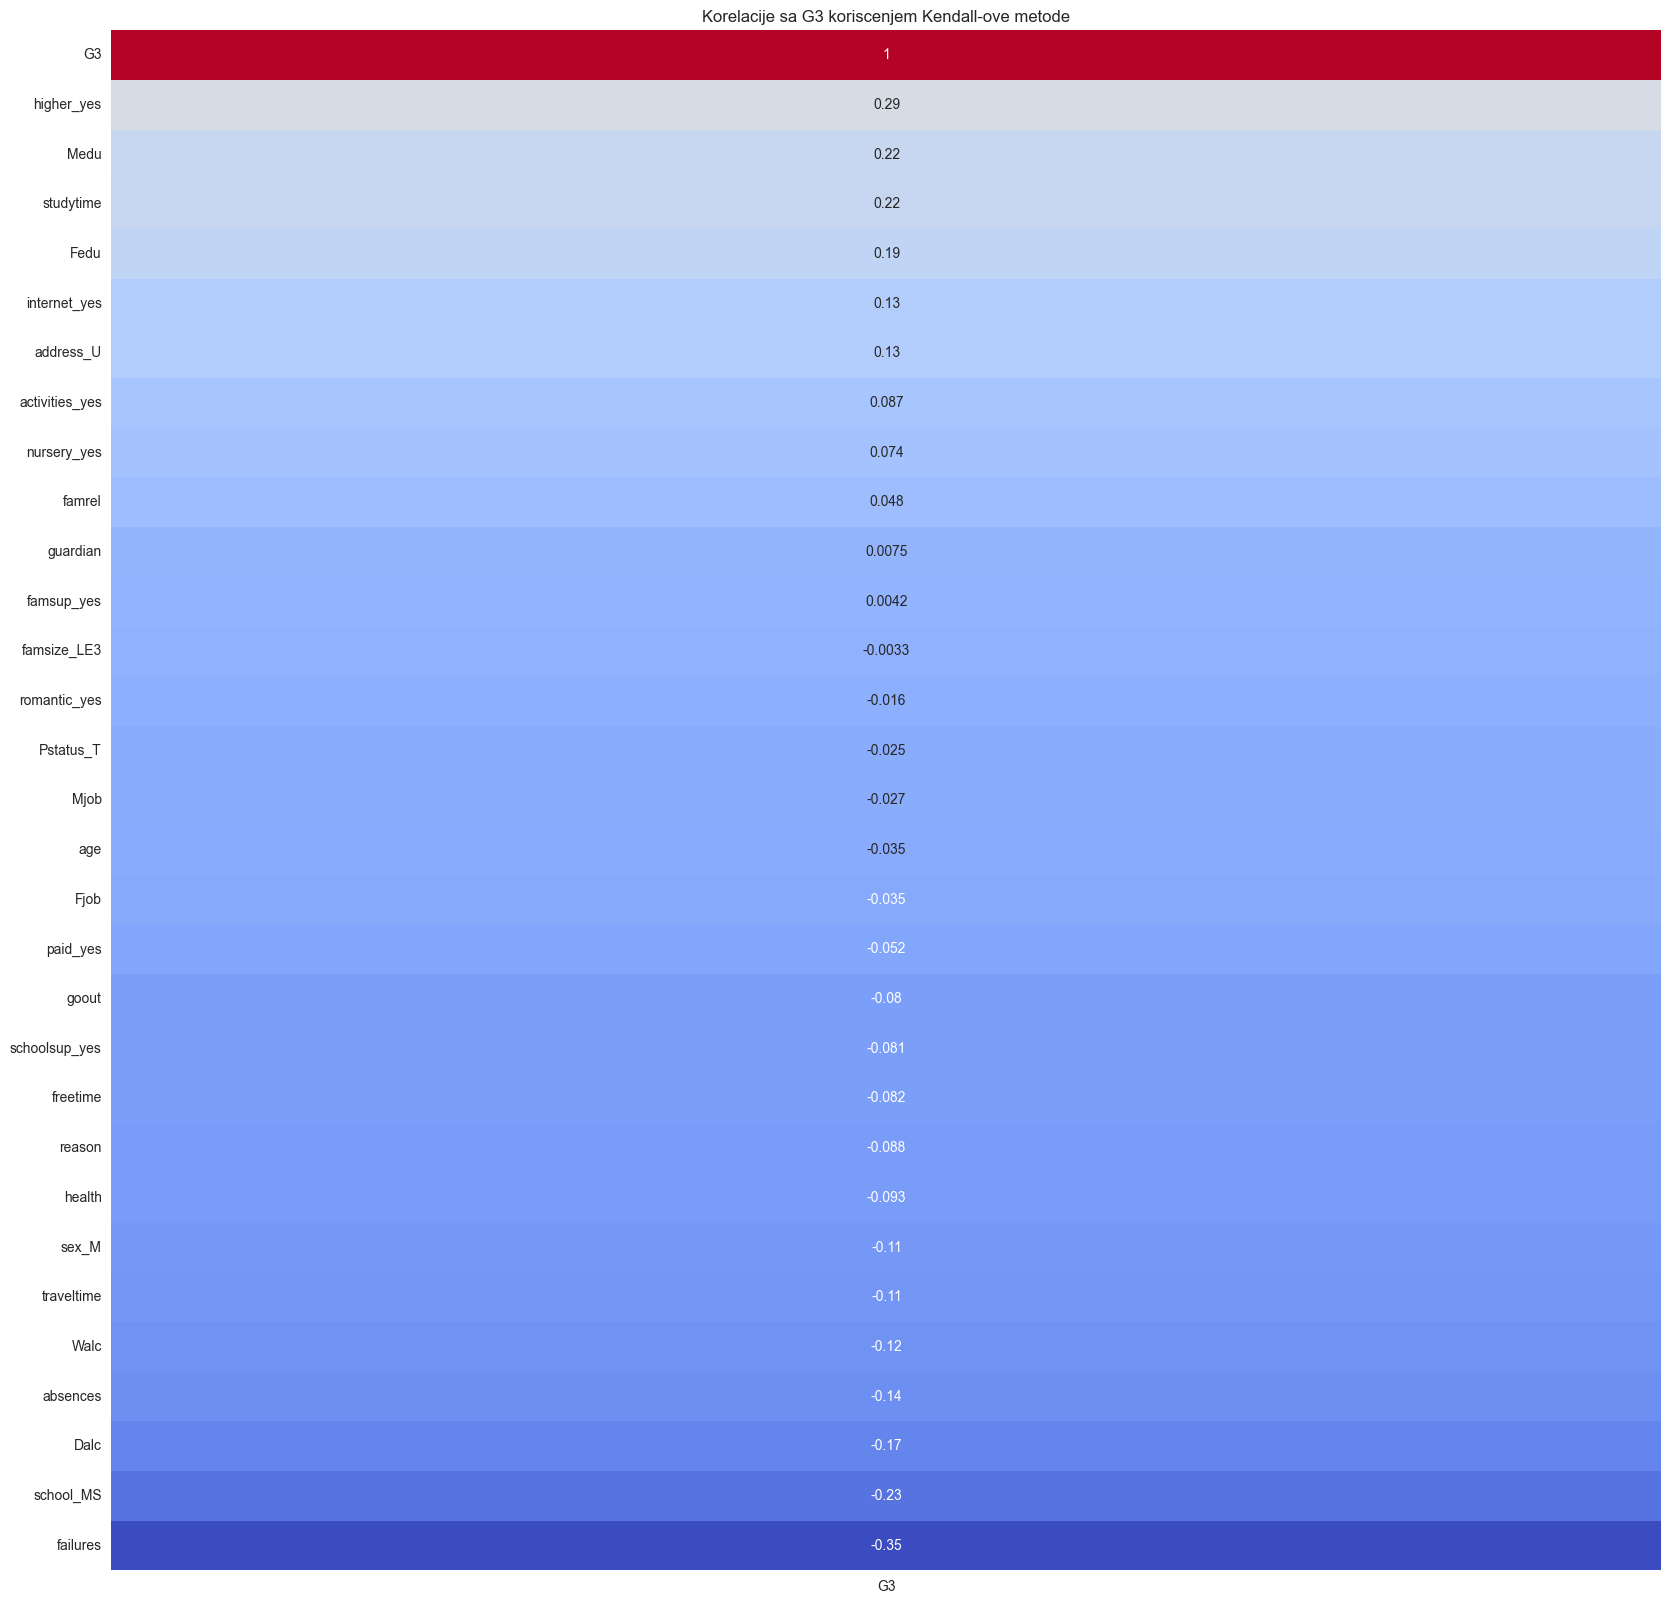

G3                1.000000
higher_yes        0.289236
Medu              0.219301
studytime         0.217030
Fedu              0.188158
internet_yes      0.131469
address_U         0.129446
activities_yes    0.087370
nursery_yes       0.073546
famrel            0.047983
guardian          0.007488
famsup_yes        0.004191
famsize_LE3      -0.003287
romantic_yes     -0.016411
Pstatus_T        -0.025438
Mjob             -0.027125
age              -0.034623
Fjob             -0.035211
paid_yes         -0.051705
goout            -0.079630
schoolsup_yes    -0.081005
freetime         -0.082039
reason           -0.088488
health           -0.092809
sex_M            -0.105085
traveltime       -0.111234
Walc             -0.124676
absences         -0.138529
Dalc             -0.170630
school_MS        -0.227141
failures         -0.351828
Name: G3, dtype: float64
Izbaceno: ['age', 'Mjob', 'Fjob', 'guardian', 'famrel', 'famsize_LE3', 'Pstatus_T', 'famsup_yes', 'romantic_yes'] kolicina: 9 Trenutno kol

In [124]:
#Korelacija G1 i G2 u odnosu na G3 nije relevantna jer je ocigledno linearna pa je izbacujemo u daljoj obradi
file.drop(columns = ['G1','G2'], inplace=True)

numeric_data = file.select_dtypes(include=['number'])

corr = numeric_data.corr(method='kendall')

#Heatmapa sa korelacijama svih promenjivih
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm',fmt='.1f')
plt.title("Correlation Heatmap")
plt.savefig('KorelacijaVelika.png',dpi=300)
plt.show()

numeric_data = file.select_dtypes(include=['number'])

corr_with_G3 = numeric_data.corr(method='kendall')['G3'].sort_values(ascending=False)

plt.figure(figsize=(20, 20))

#Heatmapa sa korelacijama u odnosu na G3
sns.heatmap(corr_with_G3.to_frame(), annot=True, cmap='coolwarm', cbar=False)
plt.title("Korelacije sa G3 koriscenjem Kendall-ove metode")
plt.savefig('KorelacijaMala.png',dpi=300)
plt.show()

#Pisanje izbacenih elemenata zbog niske korelacije
print(corr_with_G3)
dropped = [col for col in file.columns if abs(corr_with_G3[col]) < 0.05]

file = file.drop(columns=dropped)

print('Izbaceno:',dropped,'kolicina:', len(dropped),'Trenutno kolona:', len(file.columns))

file.to_csv('dummies.csv', index=False)

# **Smanjivanje dimenzionalnosti**

In [125]:
#Zbog velikog broja ulaznih kolona potrebno je smanjiti dimenzionalnost bez gubitka odrednjenih svojstava pocetnih podataka
# X = file.drop(columns=['G3'])
# y = file['G3']
#
# pca = PCA(n_components='mle', svd_solver='full')
# X_pca = pca.fit_transform(X)
#
# #Pregled toga koliko dobro svaka varijansa (novouvedena promenjiva ciji je zadatak da obuhvati sto je bolje moguce sve ostale promenljive) objasnjava podatke koje je obuhvatila u sebi i zbir tih varijansa kako bismo videli koliko dobro je zadrzana opstost podataka nakon PCA metode, u ovom slucaju veoma dobro je zadrzana
# explained_variance = pca.explained_variance_ratio_
# print("Explained variance per component:", explained_variance)
# print("Total variance retained:", 'explained_variance.sum()',format(explained_variance.sum(), '.2f'))
#
# n_components = X_pca.shape[1]
# pca_columns = [f'PC{i+1}' for i in range(n_components)]
# X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)
#
# #Imamo novi file sa novim promenljivama
# file = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)
#
# file.to_csv('dummies.csv', index=False)

# **Definisanje obucavajuceg skupa**

In [126]:
#Samo je bitna G3 promenljiva zato samo nju uzimamo kako bismo obucili modele
X = file.drop('G3', axis=1)
y = file['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
mse_dict = dict()
model_list = list()

# **Linearna regresija**

In [127]:
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
model_listlin = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
mse_dict['Linear Regression'] = model_listlin


MSE: 0.6507485517690973
MAE: 0.6689930504065817
R2: 0.3038588585407981


# **Ridge regresija sa optimizacijom parametara alpha**

In [128]:
#RidgeCV se koristi za testiranje najboljeg hiperparametra alpha za nas model, alpha se generise preko logaritamske raspodele i ocenjuje se na osnovu najmanjeg MSE-a
model = RidgeCV(alphas=np.logspace(-3,3,1000), scoring='neg_mean_squared_error', cv=5)
model.fit(X_train, y_train)

print("Najbolje alpha:", model.alpha_)

#Na osnovu najboljeg alpha treniramo model kako bismo dobili najbolje resenje
best_alpha = model.alpha_

model = Ridge(alpha = best_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
model_listridge = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
mse_dict['Ridge Regression'] = model_listridge



Najbolje alpha: 99.310918137498
MSE: 0.6520934467263833
MAE: 0.6704066996606145
R2: 0.3024201512118879


# **Lasso Regresija**

In [129]:
#Slican postupak pronalazenja najboljeg alpha parametra kao i kod Ridge regresije
model = LassoCV(alphas=np.logspace(-3, 3, 1000), cv=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Najbolje alpha:", model.alpha_)

model = Lasso(alpha=model.alpha_)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

print("MSE za najbolji model:", mean_squared_error(y_test, y_pred))
print("MAE za najbolji model:", mean_absolute_error(y_test, y_pred))
print("R2 za najbolji model:", r2_score(y_test, y_pred))
model_listlasso = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
mse_dict['Lasso Regression'] = model_listlasso

Najbolje alpha: 0.02010496416260498
MSE za najbolji model: 0.6574606374056727
MAE za najbolji model: 0.6740978424579
R2 za najbolji model: 0.2966785752441008


# **Decision tree**

Najbolji parametri: {'min_samples_split': np.int64(12), 'min_samples_leaf': np.int64(7), 'max_leaf_nodes': np.int64(5), 'criterion': 'squared_error', 'ccp_alpha': np.float64(0.024137931034482762)}
Test MSE: 0.7280
Test R2: 0.2213


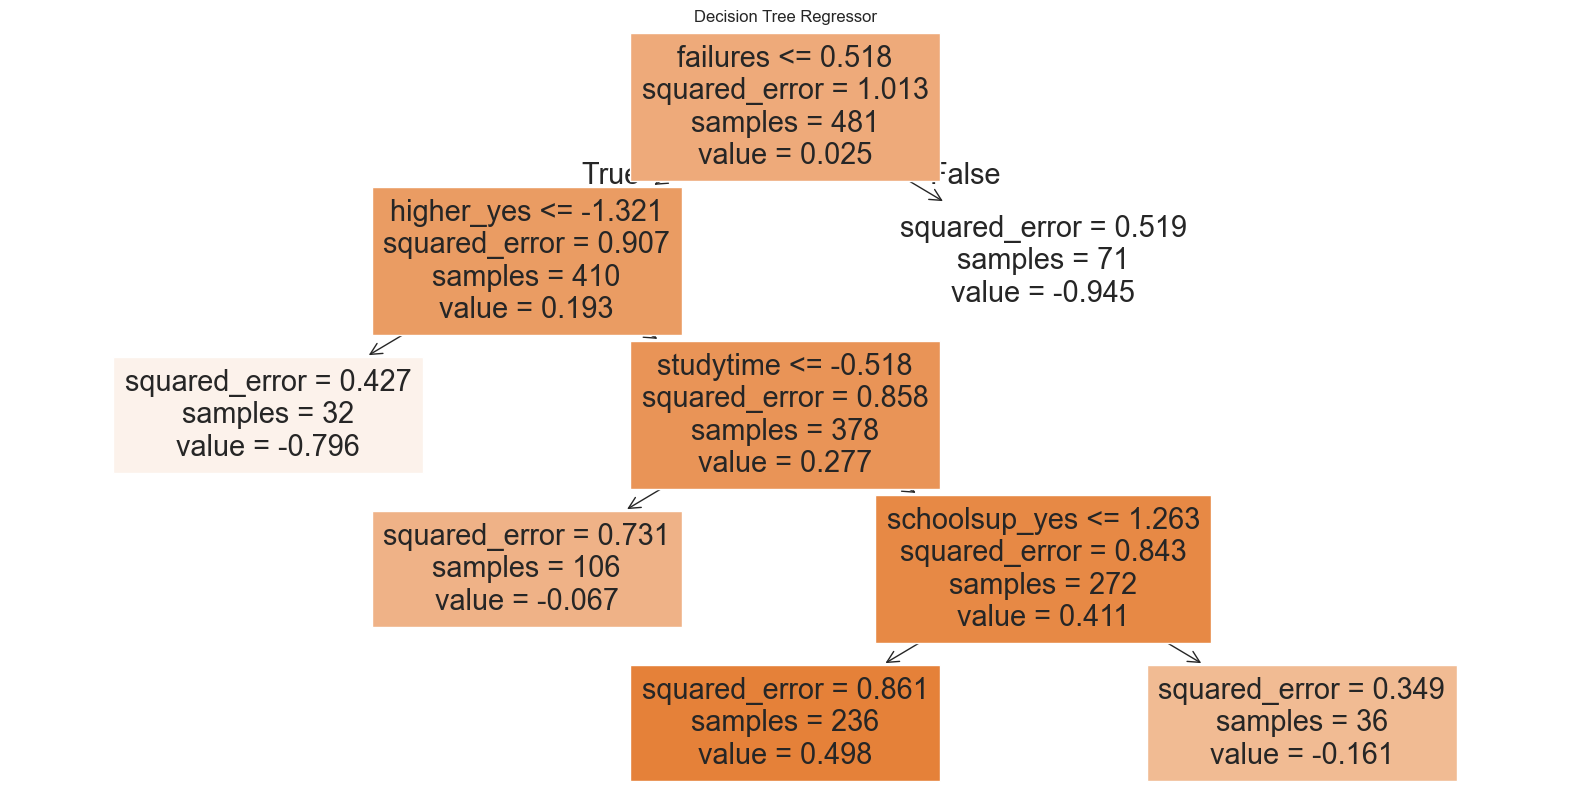

Najbolji MSE sa cross validacijom 0.7351575735624754


In [130]:
model = DecisionTreeRegressor(random_state=42)

#Hiperparametri za optimizaciju DecisionTree-a
param_distributions = {
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_split': np.arange(2, 15),
    'min_samples_leaf': np.arange(1, 10),
    'max_leaf_nodes': [None] + list(np.arange(5, 100, 5)),
    'ccp_alpha': np.linspace(0.0, 0.05, 30)
}

#U ovom slucaju koristimo RandomSearch jer bi normalan search oduzeo previse vremena, a i RandomSearch je dovoljno dobar
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Najbolji parametri:", random_search.best_params_)

#Obucavanje modela sa najboljim parametrima
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X_train.columns, filled=True)
plt.title("Decision Tree Regressor")
plt.show()

cv_mse = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Najbolji MSE sa cross validacijom", -cv_mse.mean())
model_listdt = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
mse_dict['DecisionTree'] = model_listdt

# **Random Forest**

In [131]:
model = RandomForestRegressor(random_state=42, oob_score=True,n_jobs=-1)
param={
    'n_estimators': np.linspace(100, 500, 10, dtype=int),
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True]
}

cv = RandomizedSearchCV(model, param_distributions=param, scoring='neg_mean_squared_error', cv=5,n_jobs=-1,n_iter=100)
cv.fit(X_train, y_train)

best_model = RandomForestRegressor(**cv.best_params_)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print('MSE za najbolji model:' ,mean_squared_error(y_test, y_pred))
print('R2 za najbolji model:', r2_score(y_test, y_pred))
model_listrf = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
mse_dict['RandomForest'] = model_listrf

MSE za najbolji model: 0.6345600676665729
R2 za najbolji model: 0.3211765610097298


# **Gradient Boosting**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Najbolji parametri: {'subsample': np.float64(0.7), 'n_estimators': np.int64(400), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'learning_rate': np.float64(0.01)}
Najbolji MSE sa cross validacijom: 0.7055163284472459
MSE najboljeg modela: 0.6419179820553252
R2 najboljeg modela: 0.3133053995489469


C:\Users\luca\AppData\Local\Temp\ipykernel_22964\2746357633.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




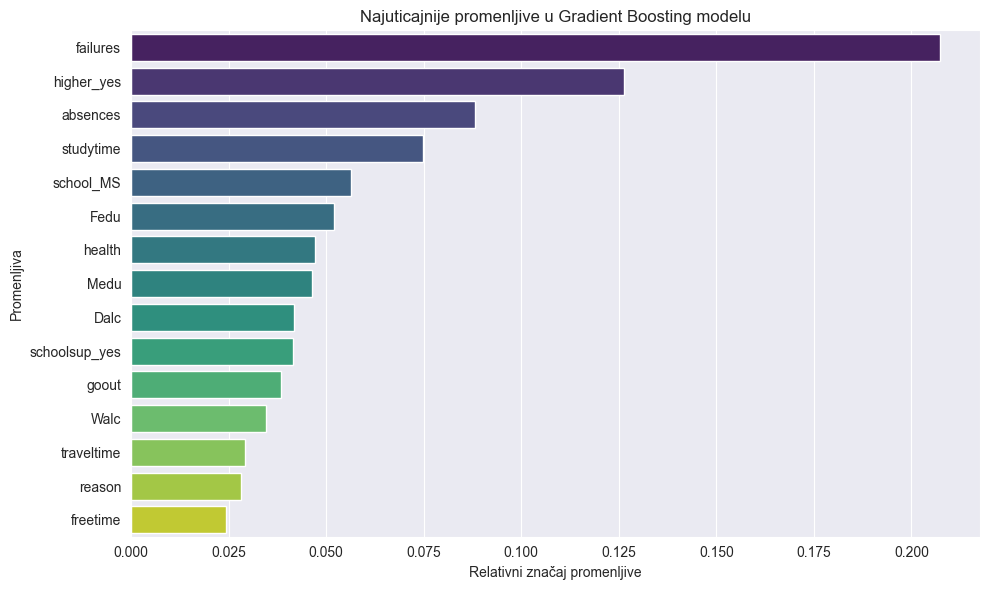


Top 10 najuticajnijih promenljivih:
      Promenljiva    Značaj
5        failures  0.207222
19     higher_yes  0.126432
11       absences  0.088031
4       studytime  0.074775
12      school_MS  0.056271
1            Fedu  0.051951
10         health  0.047255
0            Medu  0.046420
8            Dalc  0.041755
15  schoolsup_yes  0.041517


In [133]:
gb = GradientBoostingRegressor(random_state=42)

param_dist = {
    'n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': np.linspace(0.6, 1.0, 5),
    'max_features': [None, 'sqrt', 'log2']
}

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

gb_search.fit(X_train, y_train)

best_gb = gb_search.best_estimator_
y_pred = best_gb.predict(X_test)

print("Najbolji parametri:", gb_search.best_params_)
print("Najbolji MSE sa cross validacijom:", -gb_search.best_score_)
print("MSE najboljeg modela:", mean_squared_error(y_test, y_pred))
print("R2 najboljeg modela:", r2_score(y_test, y_pred))
model_listgb = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
mse_dict['GradientBoosting'] = model_listgb

feature_importance = best_gb.feature_importances_
coef_df = pd.DataFrame({
    'Promenljiva': X_train.columns,
    'Značaj': feature_importance
})

coef_df = coef_df.sort_values(by='Značaj', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(15),
    x='Značaj', y='Promenljiva', palette='viridis'
)
plt.title('Najuticajnije promenljive u Gradient Boosting modelu')
plt.xlabel('Relativni značaj promenljive')
plt.ylabel('Promenljiva')
plt.tight_layout()
plt.savefig('feature_importance_gb.png', dpi=300)
plt.show()

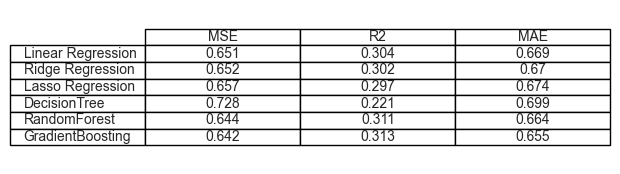

In [115]:
metrics = ['MSE', 'R2', 'MAE']  # column headers

# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(mse_dict, orient='index', columns=metrics)

df = df.round(3)

# Display as table using matplotlib
fig, ax = plt.subplots(figsize=(6, 2))  # adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')

# Save as PNG
plt.savefig("model_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

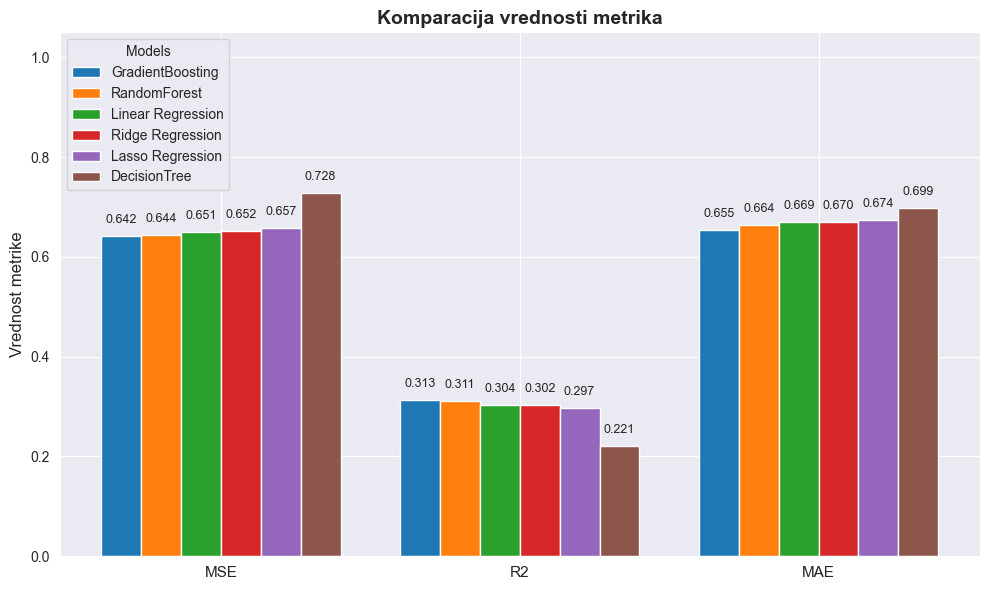

In [116]:
metrics = ['MSE', 'R2', 'MAE']
models = list(mse_dict.keys())

metric_values = {metric: [] for metric in metrics}
for metric_idx, metric in enumerate(metrics):
    for model in models:
        metric_values[metric].append((model, mse_dict[model][metric_idx]))

for metric in metrics:
    if metric == 'R2':
        metric_values[metric].sort(key=lambda x: x[1], reverse=True)
    else:
        metric_values[metric].sort(key=lambda x: x[1])  # ascending

fig, ax = plt.subplots(figsize=(10, 6))
num_metrics = len(metrics)
num_models = len(models)
group_width = 0.8
bar_width = group_width / num_models
x = np.arange(num_metrics)

colors = plt.cm.tab10.colors

for i, metric in enumerate(metrics):
    sorted_models, sorted_vals = zip(*metric_values[metric])
    offsets = np.linspace(-group_width/2 + bar_width/2, group_width/2 - bar_width/2, num_models)

    for j, (model, val) in enumerate(zip(sorted_models, sorted_vals)):
        ax.bar(x[i] + offsets[j], val, width=bar_width, color=colors[j % len(colors)],
               label=model if i == 0 else "")
        ax.text(x[i] + offsets[j], val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylabel('Vrednost metrike', fontsize=12)
ax.set_title('Komparacija vrednosti metrika', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.05)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Models', fontsize=10)

plt.tight_layout()
plt.show()
fig.savefig('metrike.png', dpi=300, bbox_inches='tight')